<img src="Figs/GEOS_logo.pdf" width="500"/>

# Invert BC, InSAR and GNSS data (weighted and damped LSM): 
## <font color=blue>"inversion_part.ipynb"</font>
#### Dec 31, 2021  <font color=red>(v. testing)</font>
##### Jeonghyeop Kim (jeonghyeop.kim@gmail.com)

1. This code is a part of the joint inversion project (project4: joint inversion of GNSS and InSAR)
2. The G-matrix will be loaded from a file which was generated in the previous step
3. Damped and Weighted LSM will be performed to find the best coefficients of the basis functions
4. The goal is to find the best linear combination of the basis functions that predicted the data sets


In [1]:
########Import modules
import numpy as np
import pandas as pd
import scipy 
import sys
import os

In [2]:
########READ Weighting and Damping parameters

# weight_for_InSAR = sys.argv[1]
# weight_for_InSAR = float(weight_for_InSAR)

# weight_for_GNSS = sys.argv[2]
# weight_for_GNSS = float(weight_for_GNSS)
# weight_for_BC = weight_for_GNSS 
# #BC velocity is from GNSS data

# damping_for_horizontal = sys.argv[3]
# damping_for_horizontal = float(damping_for_horizontal)
# damping_for_rotation = damping_for_horizontal 
# # Rotations do NOT contribute the vertical field

# damping_for_vertical = sys.argv[4]
# damping_for_vertical = float(damping_for_vertical)

In [3]:
weight_for_InSAR=5
weight_for_GNSS=1
weight_for_BC = weight_for_GNSS
damping_for_horizontal=0.01
damping_for_rotation = damping_for_horizontal
damping_for_vertical=10

In [4]:
######## How Many Basis Functions (FT #ofCells; BC #ofRotations)
HowManyBasisFunctions=np.loadtxt("HowMany.txt")
HowManyCell=int(HowManyBasisFunctions[1])
HowManyRot=int(HowManyBasisFunctions[2])

In [5]:
Gmatrix_file="G_matrix.out"
df_G_final=pd.read_csv(Gmatrix_file, sep = ',')

In [6]:
######## CHOOSE THE TYPE OF LSMs for the solution

inversion_flag = 3 

# 1 is simple LSM
# 2 is Pseudo LSM 
# 3 is Damped LSM (Ridge Regularization)

################## Testing ###########################
# 4 is Damped LSM (L-1 Norm : LASSO [scikit-learn])  #
# 5 is Damped LSM (L-1 Norm : STLSQ )                #
######################################################

# If the inversion_flag = 4,
# one damping parameter (alpah) will be used:
# alpah=damping_for_horizontal

In [7]:
# Output files
outputFILE_GNSS_XandY="vel_GNSS_pred.gmt" #Prediction for GNSS
outputFILE_D="dsd_InSAR_pred.dat" #Prediction for (Descending) InSAR
outputFILE_A="asd_InSAR_pred.dat" #Prediction for (Ascending) InSAR
outputFILE_BC_XandY="vel_BC_pred.dat" #Prediction for BC velocity field
outputFILE_model="model_coef.dat" # LSM model coefficients
outputFILE_hori="vel_horizontal_cont_pred.gmt" #Continuous horizontal field
outputFILE_vert="vel_vertical_cont_pred.dat" #Continuous vertical field 
outputFILE_strain="average_strain_cont_pred.out" #Continuous Strain rate field (midpoints)

# `STEP 1:` **BUILD a data vector,  $\vec{d}$**

In [8]:
# load input files

# 1. Boundary velocity (on the boundary)
inputBC = "BC_input.gmt"  # Boundary Condition Velocity [mm/yr]
df_inputBC = pd.read_csv(inputBC, header = None, sep =' ')
df_inputBC.columns = ['lon','lat','ve','vn','se','sn','corr']
df_inputBC.loc[:,['ve']] = df_inputBC.loc[:,['ve']]  
df_inputBC.loc[:,['vn']] = df_inputBC.loc[:,['vn']]

# 2. GNSS data
inputGNSS = "GNSS_input.gmt"  # GNSS [mm/yr]
df_inputGNSS = pd.read_csv(inputGNSS, header = None, sep=r'(?:,|\s+)', comment='#', engine='python')
df_inputGNSS.columns = ['lon','lat','ve','vn','se','sn','corr']
df_inputGNSS.loc[:,['ve']] = df_inputGNSS.loc[:,['ve']] 
df_inputGNSS.loc[:,['vn']] = df_inputGNSS.loc[:,['vn']]

# 2. InSAR Descending 
inputInSAR_D = "dsd_InSAR_input.dat" # InSAR DECS [mm/yr]
df_inputInSAR_D = pd.read_csv(inputInSAR_D, header = None, sep = ' ')
df_inputInSAR_D.columns = ['lon','lat','velo','Px','Py','Pz']  
df_inputInSAR_D.loc[:,['velo']] = df_inputInSAR_D.loc[:,['velo']]

# 3. InSAR Ascending 
inputInSAR_A = "asd_InSAR_input.dat" # InSAR ASCE [mm/yr]
df_inputInSAR_A = pd.read_csv(inputInSAR_A, header = None, sep = ' ')
df_inputInSAR_A.columns = ['lon','lat','velo','Px','Py','Pz'] 
df_inputInSAR_A.loc[:,['velo']] = df_inputInSAR_A.loc[:,['velo']]

<div class="alert alert-success">
<b>NOTE: the pointing vectors are from the perspective of the ground! NOT of the satellite </b> 
</div>

In [9]:
##################################################################################################################################
##################################################################################################################################
######################################################         GNSS         ######################################################    
##################################################################################################################################
##################################################################################################################################

# BUILD GNSS data vector along with coordinate information.
# The x components are first and then the y components of the GNSS velocity.
df_data_x_GNSS = df_inputGNSS.iloc[:,[0,1,2]]  # saved vx data on the boudnary
df_data_y_GNSS = df_inputGNSS.iloc[:,[0,1,3]]  # saved vn data on the boundary
df_data_x_GNSS=df_data_x_GNSS.rename(columns ={'ve': 'velo'}) #column name change
df_data_y_GNSS=df_data_y_GNSS.rename(columns ={'vn': 'velo'}) #column name change

# !! SORT VALUES !! # lat (ascending) first, and then lon (ascending).
# This step is very important to build the G matrix, G, which
# has rows correspoding to the rows of the data vector, d, that have
# the same coordinates!
df_data_x_GNSS=df_data_x_GNSS.sort_values(['lat', 'lon'], ascending=[True, True])
df_data_y_GNSS=df_data_y_GNSS.sort_values(['lat', 'lon'], ascending=[True, True])

# MERGE two columns (n*2) into a column (2n*1)
# > ignore_index = True : 
# >   have one continuous index numbers,
# >     ignorning each of the two dfs original indices
framesGNSS=[df_data_x_GNSS,df_data_y_GNSS]
df_data_GNSS_all=pd.concat(framesGNSS,ignore_index=True) # merge the two dataFrames into one

# SAVE GNSS velocity separately
df_data_GNSS=df_data_GNSS_all.loc[:,['velo']]


##################################################################################################################################
##################################################################################################################################
######################################################       Boundary       ######################################################    
##################################################################################################################################
##################################################################################################################################

# BUILD a boundary condition data vector along with coordinate information.
# The x components are first and then the y components of the velocity.
df_data_x_BC = df_inputBC.iloc[:,[0,1,2]]  # saved vx data on the boudnary
df_data_y_BC = df_inputBC.iloc[:,[0,1,3]]  # saved vn data on the boundary
df_data_x_BC=df_data_x_BC.rename(columns ={'ve': 'velo'}) #column name change
df_data_y_BC=df_data_y_BC.rename(columns ={'vn': 'velo'}) #column name change

# !! SORT_VALUES !! # lat (ascending) first, and then lon (ascending).
# This step is very important to build the G matrix, G, which
# has rows correspoding to the rows of the data vector, d, that have
# the same coordinates!
df_data_x_BC=df_data_x_BC.sort_values(['lat', 'lon'], ascending=[True, True])
df_data_y_BC=df_data_y_BC.sort_values(['lat', 'lon'], ascending=[True, True])

# MERGE two columns (n*2) into a column (2n*1)
# > ignore_index = True : 
# >   have one continuous index numbers,
# >     ignorning each of the two dfs original indices
framesBC=[df_data_x_BC,df_data_y_BC]
df_data_BC_all=pd.concat(framesBC,ignore_index=True) # merge the two dataFrames into one

# SAVE BC velocity separately
df_data_BC=df_data_BC_all.loc[:,['velo']]


##################################################################################################################################
##################################################################################################################################
######################################################        InSAR         ######################################################    
##################################################################################################################################
##################################################################################################################################

# BUILD a InSAR data vector along with coordinate information.
# The rows of the InSAR data vector is in the order of descending-orbit data, and ascending-orbit data. 
# Track the pointing vector values together with the rate data for the G-matrix.

# !! SORT_VALUES !! # lat (ascending) first, and then lon (ascending).
# This step is very important to build the G matrix, G, which
# has rows correspoding to the rows of the data vector, d, that have
# the same coordinates!
df_inputInSAR_D=df_inputInSAR_D.sort_values(['lat', 'lon'], ascending=[True, True])
df_inputInSAR_A=df_inputInSAR_A.sort_values(['lat', 'lon'], ascending=[True, True])

# MERGE two columns (n*2) into a column (2n*1)
# > ignore_index = True : 
# >   have one continuous index numbers,
# >     ignorning each of the two dfs original indices
framesInSAR=[df_inputInSAR_D,df_inputInSAR_A]
df_data_InSAR_all=pd.concat(framesInSAR,ignore_index=True) # merge the four dataFrames into one

# SAVE InSAR velocity separately
df_data_InSAR = df_data_InSAR_all.loc[:,['velo']]

In [10]:
# Merge the GNSS, InSAR, and BC data vectors into the final data vector
framesFinal = [df_data_GNSS, df_data_InSAR, df_data_BC]
df_data_total = pd.concat(framesFinal,ignore_index=True) # merge the two dataFrames into one

In [11]:
df_data_total.columns = ['data'] # DATA VECTOR [[GNSSx], [GNSSy], [InSAR_D], [InSAR_A], [BCx], [BCy]]

In [12]:
if len(df_data_total)!=len(df_G_final):
    print("WARNING: Something went wrong!")

# `STEP 3:` RUN Joint Inversion (LSM)
> G-matrix = **df_G_final** \
> data vec = **df_data_total**

In [13]:
# Build a Diagonal Weighting Matrix W
nGNSS=len(df_data_GNSS)
nBC=len(df_data_BC)
nInSAR=len(df_data_InSAR)
nTotal=len(df_data_total)

errorGNSS = np.ones(nGNSS)*weight_for_GNSS
errorInSAR = np.ones(nInSAR)*weight_for_InSAR 
errorBC = np.ones(nBC)*weight_for_BC

errorTotal = np.concatenate((errorGNSS,errorInSAR, errorBC),axis=0)
errorTotalinv = 1/errorTotal
W = np.diag(errorTotalinv)

# convert into a dataframe
dfW = pd.DataFrame(W)

# When calculating predictions, the non-weighted G-matrix is needed. 
# SAVE it!
df_G_final_save = df_G_final

# When calculating the misfit, the non-weighted data is needed. 
# SAVE it!
df_data_total_save = df_data_total

In [14]:
# Multiply the Diagonal Weighting Matrix dfW to the data vector and Gmatrix

df_G_final = dfW @ df_G_final_save
df_data_total = dfW @ df_data_total_save

In [15]:
df_G_prime = df_G_final.transpose() 

# G'G
# >Two different ways to compute a matrix multiplication
# >1st method
GpG1=df_G_prime.dot(df_G_final) #G'G
# >2nd method
GpG2=df_G_prime @ df_G_final #G'G
# >These results are same.
# >Let's take the second one as G'G
GpG = GpG2 #GpG is G'G
# inv(G'G)
# > Two different ways to obtain inverse matrix
# > 1st method: np.linalg.inv 


###############################
## inv(G'G)*G'*d = model(LSM) #
###############################
if inversion_flag == 1:
    #  1st method: np.linalg.inv
    df_inv_GpG = pd.DataFrame(np.linalg.inv(GpG.to_numpy()), GpG.columns, GpG.index)
    df_model1=df_inv_GpG@df_G_prime@df_data_total #inversion
    
elif inversion_flag == 2:
    #  2nd method: np.linalg.pinv (Moore-Penrose inverse (SVD))
    df_pinv_GpG = pd.DataFrame(np.linalg.pinv(GpG.to_numpy()), GpG.columns, GpG.index)
    df_model1=df_pinv_GpG@df_G_prime@df_data_total #pseudo inversion
    
elif inversion_flag == 3:
    #  3rd method: Damping (Tikhonov Regularization)
    alp=damping_for_horizontal*np.ones((HowManyCell*3,1))**2 # damping parameter for hori
    bet=damping_for_vertical*np.ones((HowManyCell,1))**2 # damping parameter for vert
    gam=damping_for_rotation*np.ones((HowManyRot*3,1))**2 # damping parameter for rot
    array_tuple = (alp, bet, gam)
    lamb = np.vstack(array_tuple) 
    lamb = lamb[:,0]
    damping_matrix=np.diag(lamb) # a*a*I    
    GpG_damping = GpG + damping_matrix #(G'G + a*a*I)
    GpD=df_G_prime@df_data_total
    df_model_damping= np.linalg.solve(GpG_damping,GpD)
    df_model1=pd.DataFrame(df_model_damping[:,0])
    df_model1.index=df_G_final_save.columns.values  

    
    
elif inversion_flag == 4: 
#  4th method [Testing]: scikit-learn LASSO (L1-norm)

    # For the Frame
    df_pinv_GpG = pd.DataFrame(np.linalg.pinv(GpG.to_numpy()), GpG.columns, GpG.index)
    df_model1=df_pinv_GpG@df_G_prime@df_data_total #pseudo inversion    
    
    
    ## Cross Validation
    # np_G_final = df_G_final.to_numpy()
    # np_data_total= df_data_total.to_numpy()
    # np_data_total = np.squeeze(np_data_total)
    # from sklearn import linear_model
    # from sklearn import model_selection
    ## reg = linear_model.LassoCV(cv=10).fit(np_G_final, np_data_total)
    # lasso = linear_model.Lasso(random_state=0, max_iter=10000)
    # alphas = np.logspace(-4, -0.5, 30)
    # tuned_parameters = [{'alpha': alphas}] 
    # clf = model_selection.GridSearchCV(lasso, tuned_parameters, cv=10, refit=False)
    # clf.fit(np_G_final, np_data_total)
    # XL1 = linear_model.Lasso(alpha=clf.best_params_['alpha'])
    # XL1.fit(np_G_final, np_data_total)
    # s_L1 = XL1.coef_
    # scores = clf.cv_results_['mean_test_score']
    # scores_std = clf.cv_results_['std_test_score']
    # plt.semilogx(alphas, scores,'r-')
    # # plot error lines showing +/- std. errors of the scores
    # std_error = scores_std / np.sqrt(10)
    # plt.semilogx(alphas, scores + std_error, 'k--')
    # plt.semilogx(alphas, scores - std_error, 'k--')
    # plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.1,color='k')
    # plt.ylabel('CV score +/- std error')
    # plt.xlabel('alpha')
    # plt.axhline(np.max(scores), linestyle='--', color='.5')
    # plt.xlim([alphas[-1], alphas[0]])
    # plt.show()
    
    
    np_G_final = df_G_final.to_numpy()
    np_data_total= df_data_total.to_numpy()
    np_data_total = np.squeeze(np_data_total)
    from sklearn import linear_model  
    clf = linear_model.Lasso(alpha=damping_for_horizontal)
    clf.fit(np_G_final, np_data_total)
    s_L1 = clf.coef_
    a=s_L1.reshape(len(s_L1),1)
    df_model1.loc[:,['data']]=a
    ###### s_L1 to pandas Df named 'df_model1'
    
    
else:
    #  5th method [Testing]: STLSQ method (L1-norm)
    # Started from L2-norm
    alp=3*np.ones((HowManyCell*3,1))**2 # damping parameter for hori
    bet=3*np.ones((HowManyCell,1))**2 # damping parameter for vert
    gam=3*np.ones((HowManyRot*3,1))**2 # damping parameter for rot
    array_tuple = (alp, bet, gam)
    lamb = np.vstack(array_tuple) 
    lamb = lamb[:,0]
    damping_matrix=np.diag(lamb) # a*a*I    
    GpG_damping = GpG + damping_matrix #(G'G + a*a*I)
    GpD=df_G_prime@df_data_total
    df_model_damping= np.linalg.solve(GpG_damping,GpD)
    df_model1=pd.DataFrame(df_model_damping[:,0])
    df_model1.index=df_G_final_save.columns.values  

    # STLSQ 
    x0 = df_model1.to_numpy() #initialize with L2 solution
    from scipy.optimize import minimize
    def L1_norm(x):
        return np.linalg.norm(x,ord=1) 
    constr = ({'type' : 'eq', 'fun' : lambda x: df_G_final @ x - df_data_total})
    res = minimize(L1_norm, x0, method = 'SLSQP', constraints = constr)
    s_L1 = res.x
 
    df_model1.loc[:,['data']]=s_L1
    ###### s_L1 to pandas Df named 'df_model1'




df_data_predicted = df_G_final_save @ df_model1
# 'df_G_final_save' is the non-weighted G-matrix

# squared norm2 misfit
df_norm2=(df_data_total_save.to_numpy()-df_data_predicted.to_numpy())**2
df_norm2=df_norm2.sum()

In [16]:
# Separate the predicted data vector into
# (1) GNSS x and y
# (2) InSAR 1
# (3) InSAR 2
# (4) BC vel x and y

num_velo_pointGNSS=len(df_data_GNSS_all) # GNSS
num_velo_pointGNSS=int(num_velo_pointGNSS)

num_velo_pointInSAR=len(df_data_InSAR_all)/2  # 2 InSAR data sets in a column vector
num_velo_pointInSAR=int(num_velo_pointInSAR)

num_velo_pointBC=len(df_data_BC_all) #BC vel
num_velo_pointBC=int(num_velo_pointBC)


####################
#####  GNSS  #######
####################

#GNSS predicted x
df_prediction_GNSS_x=df_data_predicted.iloc[0:int(num_velo_pointGNSS/2)] 
df_prediction_GNSS_x=df_prediction_GNSS_x.reset_index(drop=True)
#BC predicted y
df_prediction_GNSS_y=df_data_predicted.iloc[int(num_velo_pointGNSS/2):num_velo_pointGNSS] 
df_prediction_GNSS_y=df_prediction_GNSS_y.reset_index(drop=True)

# Coordinate Template To Save Predicted BC Data
df_GNSS_save = df_data_GNSS_all.iloc[0:int(num_velo_pointGNSS/2),[0,1]]

df_save_GNSS_XandY = df_GNSS_save.reset_index(drop=True)
df_save_GNSS_XandY['vx'] = df_prediction_GNSS_x
df_save_GNSS_XandY['vn'] = df_prediction_GNSS_y
df_save_GNSS_XandY['se'] = np.zeros(len(df_prediction_GNSS_y))
df_save_GNSS_XandY['sn'] = np.zeros(len(df_prediction_GNSS_y))
df_save_GNSS_XandY['corr'] = np.zeros(len(df_prediction_GNSS_y))



#####################
#####  INSAR  #######
#####################

df_prediction_D=df_data_predicted.iloc[num_velo_pointGNSS:num_velo_pointGNSS+num_velo_pointInSAR] #dLOS Descending
df_prediction_D=df_prediction_D.reset_index(drop=True)

df_prediction_A=df_data_predicted.iloc[num_velo_pointGNSS+num_velo_pointInSAR:num_velo_pointGNSS+2*num_velo_pointInSAR] #dLOS Ascending
df_prediction_A=df_prediction_A.reset_index(drop=True)

# Coordinate Template To Save Predicted InSAR Data
df_InSAR_save = df_inputInSAR_D.iloc[:,[0,1]]   

df_save_D = df_InSAR_save.reset_index(drop=True)
df_save_D['dLOS'] = df_prediction_D #append predicted dLOS Descending
df_save_D['dLOS'] = df_save_D['dLOS']

df_save_A = df_InSAR_save.reset_index(drop=True)
df_save_A['dLOS'] = df_prediction_A #append predicted dLOS Ascending
df_save_A['dLOS'] = df_save_A['dLOS']

########################
#####  Boundary ########
########################

#BC predicted x
df_prediction_BC_x=df_data_predicted.iloc[num_velo_pointGNSS+2*num_velo_pointInSAR:num_velo_pointGNSS+2*num_velo_pointInSAR+int(num_velo_pointBC/2)] 
df_prediction_BC_x=df_prediction_BC_x.reset_index(drop=True)
#BC predicted y
df_prediction_BC_y=df_data_predicted.iloc[num_velo_pointGNSS+2*num_velo_pointInSAR+int(num_velo_pointBC/2):num_velo_pointGNSS+2*num_velo_pointInSAR+num_velo_pointBC] 
df_prediction_BC_y=df_prediction_BC_y.reset_index(drop=True)
# Coordinate Template To Save Predicted BC Data
df_BC_save = df_data_BC_all.iloc[0:int(num_velo_pointBC/2),[0,1]]
df_save_BC_XandY = df_BC_save.reset_index(drop=True)
df_save_BC_XandY['vx'] = df_prediction_BC_x
df_save_BC_XandY['vn'] = df_prediction_BC_y
df_save_BC_XandY['se'] = np.zeros(len(df_prediction_BC_y))
df_save_BC_XandY['sn'] = np.zeros(len(df_prediction_BC_y))
df_save_BC_XandY['corr'] = np.zeros(len(df_prediction_BC_y))


In [17]:
# SAVE predicted data sets
df_save_GNSS_XandY.to_csv(outputFILE_GNSS_XandY, header=None, index=None, sep=' ', float_format='%g')
df_save_D.to_csv(outputFILE_D, header=None, index=None, sep=' ',float_format='%g')
df_save_A.to_csv(outputFILE_A, header=None, index=None, sep=' ',float_format='%g')
df_save_BC_XandY.to_csv(outputFILE_BC_XandY, header=None, index=None, sep=' ', float_format='%g')

In [18]:
# SAVE model coefficients
df_model1.to_csv(outputFILE_model, header=None, index=None, float_format='%g')

In [19]:
print(df_norm2)

chi-square statistics is : 42212.473216 [mm/yr]**2


<div class="alert alert-warning">
<div class="alert--icon"> <i class="far fa-times-circle"></i> </div>
    <p> Weighted Tikhonov Regularization works pretty well. </p>
    <b> But this approach cannot resolve short-wavelength features. </b>
</div>

<div class="alert alert-success">
    <b> TRY the L1 regularization. </b>
</div>

# `STEP 4:` Obtain 3-D continuous surface velocity & horizontal strain field

In [20]:
Gmatrix_file_cont_hori="G_matrix_cont_hori.out"
Gmatrix_file_cont_vert="G_matrix_cont_vert.out"
Gmatrix_file_strain="G_matrix_strain.out"

df_G_horizontal_continuous=pd.read_csv(Gmatrix_file_cont_hori, sep = ',')
df_G_vertical_continuous=pd.read_csv(Gmatrix_file_cont_vert, sep = ',')
df_G_horizontal_continuous_strain=pd.read_csv(Gmatrix_file_strain, sep = ',')
########################################################################################
#                         Horizontal continuous velocity model.                        #
########################################################################################

continuous_hor_model = df_G_horizontal_continuous.to_numpy() @ df_model1.to_numpy()
continuous_num=int(len(continuous_hor_model)/2)
Xmodel=continuous_hor_model[0:continuous_num,0]
Ymodel=continuous_hor_model[continuous_num:,0]


########################################################################################
#                         Vertical continuous velocity model.                          #
########################################################################################

continuous_ver_model = df_G_vertical_continuous.to_numpy() @ df_model1.to_numpy()[HowManyCell*3:HowManyCell*4,]
Zmodel=continuous_ver_model[:,0]


########################################################################################
#                         Horizontal continuous strain rate model.                     #
########################################################################################

continuous_hor_model_strain = df_G_horizontal_continuous_strain.to_numpy() @ df_model1.to_numpy()
midpointnum=int(len(continuous_hor_model_strain)/3)
eXXmodel=continuous_hor_model_strain[0:midpointnum,0]
eYYmodel=continuous_hor_model_strain[midpointnum:2*midpointnum,0]
eXYmodel=continuous_hor_model_strain[2*midpointnum:3*midpointnum,0]

In [21]:
# SAVE continuous 3-D velocity field.
inputfile_zzz_continuous = "./basis_functions_FT/vel_vert_FT_1_4_continuous.gmt"
df_zzz_continuous=pd.read_csv(inputfile_zzz_continuous, header=None, sep=r'(?:,|\s+)',
                           comment='#', engine='python')
df_zzz_continuous.columns = ['lon','lat','vz']
df_zzz_continuous=df_zzz_continuous.sort_values(['lat','lon'], ascending=[True, True])
df_zzz_continuous=df_zzz_continuous.reset_index(drop=True)


df_hori = df_zzz_continuous.loc[:,['lon','lat']]
df_hori['ve'] = Xmodel
df_hori['vn'] = Ymodel
df_hori['se'] = np.zeros(len(Ymodel))
df_hori['sn'] = np.zeros(len(Ymodel))
df_hori['corr'] = np.zeros(len(Ymodel))

df_vert = df_zzz_continuous.loc[:,['lon','lat']]
df_vert['vz'] = Zmodel

df_hori.to_csv(outputFILE_hori, header=None, index=None, sep=' ', float_format='%g')
df_vert.to_csv(outputFILE_vert, header=None, index=None, sep=' ', float_format='%g')

In [22]:
# SAVE horizontal strain rate field.

inputfile_strain_xrot = "./basis_functions_BC/average_strain_BC_x_001_RECTANGULAR.out" # x-rot 
df_xrot_strain=pd.read_csv(inputfile_strain_xrot ,header=None, sep=r'(?:,|\s+)', 
                           comment='#', engine='python')
df_xrot_strain.columns = ['num','lat','lon','exx','eyy','exy','sxx','syy','sxy']
df_xrot_exx = df_xrot_strain.iloc[:,[2,1,3]]  # saved exx basis function on the midpoints for strain
df_xrot_exx=df_xrot_exx.rename(columns ={'exx': 'strain'}) #column name change
df_xrot_exx=df_xrot_exx.sort_values(['lat', 'lon'], ascending=[True, True])



df_strain=df_xrot_exx.loc[:,['lon','lat']]
df_strain['exx']=eXXmodel
df_strain['eyy']=eYYmodel
df_strain['exy']=eXYmodel
df_strain['num']=range(len(eXXmodel))
df_strain['sxx']=np.zeros((len(eXXmodel),))
df_strain['syy']=np.zeros((len(eXXmodel),))
df_strain['sxy']=np.zeros((len(eXXmodel),))
df_strain_save = df_strain[['num','lat','lon','exx','eyy','exy','sxx','syy','sxy']]

df_strain_save.to_csv(outputFILE_strain, header=None, index=None, sep=' ', float_format='%g')

In [23]:
df_model1

,0
GexxXPx+GexxYPy 1,-0.126390
GeyyXPx+GeyyYPy 1,-0.087683
GexyXPx+GexyYPy 1,-0.038517
GexxXPx+GexxYPy 2,0.015874
GeyyXPx+GeyyYPy 2,-0.050507
...,...
GyrotXPx+GyrotYPy 75,-0.421873
GzrotXPx+GzrotYPy 75,0.133626
GxrotXPx+GxrotYPy 76,-0.081783
GyrotXPx+GyrotYPy 76,-0.084936


In [24]:
import matplotlib.pyplot as plt

/var/folders/kt/zdsy5jqj2tn2lbh6qhjxdlgh0000gn/T/ipykernel_2796/2214478011.py:3: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])


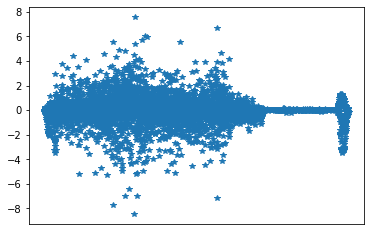

In [25]:
fig, ax = plt.subplots()
ax.plot(df_model1,'*')
ax.set_xticks([])
plt.show()